#### 2. Small dataset using 500 entries. Data filtering with mongodb. Preprocessing and analysis using scikit-learn.

In [1]:
from pymongo import MongoClient
client = MongoClient(port=#####) # the port number is set by the user from SSH tunnel
db = client.pubmed_ad # database name

In [2]:
client.pubmed_ad.alz.count()

130672

In [3]:
db.alz.count()

130672

In [4]:
# create lists containing BOTH abstracts (AB) or titles (TI)
cursor = db.alz.find(
    { 'AB': { '$ne': None }, 'TI': {'$ne': None}},
    { 'AB': 1, '_id': 0, 'TI': 1 }
).limit(500)

docs = list(cursor)

In [ ]:
# check out an entry
docs[5]

In [5]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#### Topic modeling and clustering using abstracts

In [6]:
# test set of 500 abstracts
docs_ab = []

for i, abstract in enumerate(d['AB'] for d in docs): 
    docs_ab.append(abstract)

In [ ]:
# check out an entry
docs_ab[11]

In [7]:
tfidf_test = TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=2)
tfidf_vecs = tfidf_test.fit_transform(docs_ab)
test_df = pd.DataFrame(tfidf_vecs.todense(), 
             columns=tfidf_test.get_feature_names()
            )
#test_df.sample(5)

In [ ]:
# same as above but streamlined as a pipeline

In [11]:
# VSMs.ipynb
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# steps to try: TfidfVectorizor, TruncSVD/NMF, Normalizer, KMeans/RF AND tSNE

pipe = [
    ('tfidf', TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=3)),
    ('lsa', TruncatedSVD(n_components=300)),
    ('norm', Normalizer())
]
pipe = Pipeline(pipe)


In [12]:
dtm_svd = pipe.fit_transform(docs_ab)
dtm_svd_df = pd.DataFrame(dtm_svd)

In [13]:
#print(dtm_svd.shape)
#print(dtm_svd[0])
# each adds up to ~1 (rounding errors)
np.linalg.norm(dtm_svd[55])

1.0

In [14]:
# digits_clustering.ipynb
# use this cell and next to plot inertia to see if there is an elbow indicating clear k to use
from sklearn import metrics
SSEs = []
Sil_coefs = []
Inertia = []
for k in range(2,20):
    print('Cluster numbers: ' + str(k))
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(dtm_svd)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(dtm_svd, labels, metric='euclidean'))
    # SSEs.append(get_SSE(X_digits, labels)) # The SSE is just inertia, we
    SSEs.append(km.inertia_)            # could have just said km.inertia_

Cluster numbers: 2
Cluster numbers: 3
Cluster numbers: 4
Cluster numbers: 5
Cluster numbers: 6
Cluster numbers: 7
Cluster numbers: 8
Cluster numbers: 9
Cluster numbers: 10
Cluster numbers: 11
Cluster numbers: 12
Cluster numbers: 13
Cluster numbers: 14
Cluster numbers: 15
Cluster numbers: 16
Cluster numbers: 17
Cluster numbers: 18
Cluster numbers: 19


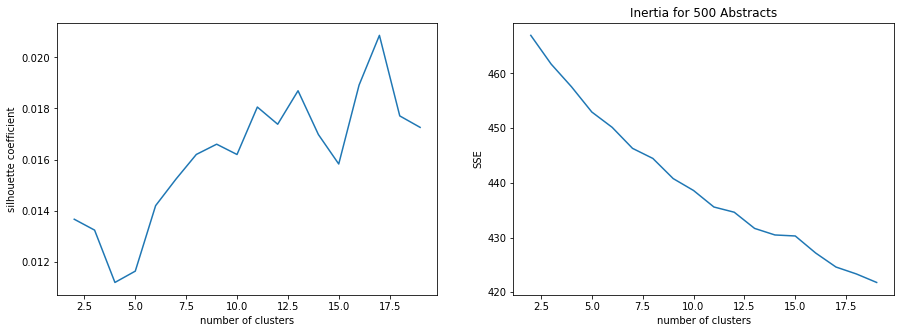

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
# the silhouete coefficient is (b - a) / max(a, b), where b(i) is the average distance between a point i and every other point from the closest cluster; 
# and a(i) is the average distance between a point i and every other point within its own cluster.  It has a value from -1,1. 1 means it belongs to the cluster.
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_title('Inertia for 500 Abstracts')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

# no obvious elbow to determine k

In [16]:
# try Mean Shift, which does not require specifying k (num of clusters)
from sklearn.cluster import MeanShift

ms = MeanShift()
temp = ms.fit_predict(dtm_svd)

In [52]:
print(temp)
len(temp)
# output says all articles belong to cluster 0
# try something else...

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

500

In [18]:
# KMeans using 10 clusters (arbitrary pick)
km = KMeans(n_clusters=10)
km.fit(dtm_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
# centroids
mu_digits = km.cluster_centers_
mu_digits.shape

(10, 300)

In [ ]:
# what are the labels? Do not confuse the label with the digit prediction
temp = (pd.Series(km.labels_))
print(sorted(temp.unique()))
print(temp.shape)

In [20]:
clusters = km.fit_predict(dtm_svd)
#print(clusters)

from collections import Counter

Counter(clusters)

Counter({0: 53, 1: 23, 2: 90, 3: 34, 4: 39, 5: 47, 6: 66, 7: 28, 8: 64, 9: 56})

In [21]:
# Goal here is to give each cluster a name/names based km.cluster_centers_ (set to mu_digits from earlier code)
# and mapping to feature names from TruncSVD (pipe.steps[1][1] from pipeline).

from sklearn.feature_extraction.text import TfidfTransformer

print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: mitochondrial cells metal diseases protein oxidative il disease inflammatory stress
Cluster 1: abeta amyloid beta ad induced cn peptide deposition peptides cognitive
Cluster 2: tau ad csf phosphorylation levels protein plasma biomarkers amyloid disease
Cluster 3: ad clinical disease trials amyloid biomarkers pd studies alzheimer preclinical
Cluster 4: mice app ad abeta levels expression memory transgenic protein effects
Cluster 5: brain diseases disease alpha using human imaging method amyloid alzheimer
Cluster 6: apoe risk variants allele genetic ad associated association snps rare
Cluster 7: patients ad mci cognitive volume memory mild age subjects hc
Cluster 8: dementia care cognitive use ci risk participants health data life
Cluster 9: compounds inhibitors ache inhibitory compound activity buche inhibition synthesized potent


In [22]:
from sklearn.manifold import TSNE

dtm_svd_vis = TSNE().fit_transform(dtm_svd_df)
dtm_svd_vis_df = pd.DataFrame(TSNE().fit_transform(dtm_svd_df))

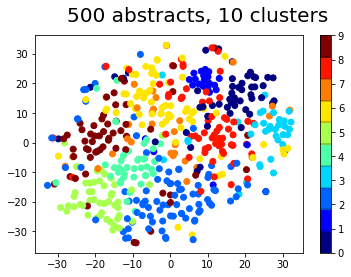

In [71]:
plt.scatter(dtm_svd_vis_df.iloc[: , :1], dtm_svd_vis_df.iloc[: , -1:], c = clusters, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(drawedges = True)
plt.suptitle('500 abstracts, 10 clusters', fontsize=20)

In [65]:
plt.colorbar?

In [24]:
# LSA_and_Classification.ipynb from Week7/word2vec
# topic modeling!

def print_topic_top_words(pipe, n_topics=10, n_words=5):
    cv = pipe.steps[0][1]
    model = pipe.steps[1][1]
    feature_names = cv.get_feature_names()
    
    for topic_num in range(n_topics):
        topic_mat = model.components_[topic_num]
        
        print('Topic {}:'.format(topic_num + 1).center(80))
        
        topic_values = sorted(zip(topic_mat, feature_names), 
                              reverse=True)[:n_words]
        print(' '.join([y for x,y in topic_values]))
        print('-'*80)
        
print_topic_top_words(pipe)

                                    Topic 1:                                    
ad abeta tau disease brain
--------------------------------------------------------------------------------
                                    Topic 2:                                    
dementia patients mci cognitive ad
--------------------------------------------------------------------------------
                                    Topic 3:                                    
tau csf ad phosphorylation biomarkers
--------------------------------------------------------------------------------
                                    Topic 4:                                    
abeta app mice memory ad
--------------------------------------------------------------------------------
                                    Topic 5:                                    
tau mice expression associated memory
--------------------------------------------------------------------------------
                           

#### Try with pubmed titles. Do the clusters match up?

In [25]:
# test set of 500 titles
docs_ti = []

for i, title in enumerate(d['TI'] for d in docs): 
    docs_ti.append(title)

In [ ]:
# check out an entry
docs_ti[11]

In [26]:
dtm2_svd = pipe.fit_transform(docs_ti)
dtm2_svd_df = pd.DataFrame(dtm2_svd)

In [27]:
SSEs2 = []
Sil_coefs2 = []
Inertia2 = []
for k in range(2,20):
    print('Cluster numbers: ' + str(k))
    km2 = KMeans(n_clusters=k, random_state=1)
    km2.fit(dtm2_svd)
    labels2 = km2.labels_
    Sil_coefs2.append(metrics.silhouette_score(dtm2_svd, labels2, metric='euclidean'))
    # SSEs.append(get_SSE(X_digits, labels)) # The SSE is just inertia, we
    SSEs2.append(km2.inertia_)            # could have just said km.inertia_

Cluster numbers: 2
Cluster numbers: 3
Cluster numbers: 4
Cluster numbers: 5
Cluster numbers: 6
Cluster numbers: 7
Cluster numbers: 8
Cluster numbers: 9
Cluster numbers: 10
Cluster numbers: 11
Cluster numbers: 12
Cluster numbers: 13
Cluster numbers: 14
Cluster numbers: 15
Cluster numbers: 16
Cluster numbers: 17
Cluster numbers: 18
Cluster numbers: 19


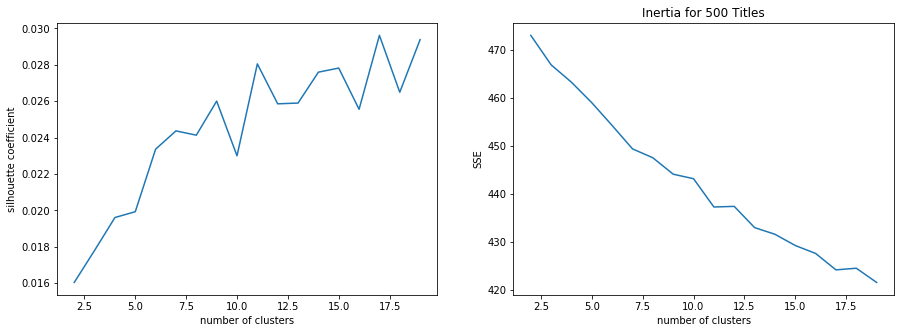

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
# the silhouete coefficient is (b - a) / max(a, b), where b(i) is the average distance between a point i and every other point from the closest cluster; 
# and a(i) is the average distance between a point i and every other point within its own cluster.  It has a value from -1,1. 1 means it belongs to the cluster.
ax1.plot(k_clusters, Sil_coefs2)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs2)
ax2.set_title('Inertia for 500 Titles')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

# similar to abstracts, no obvious elbow to determine k for titles

In [29]:
km2 = KMeans(n_clusters=10)
km2.fit(dtm2_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [30]:
clusters_ti = km2.fit_predict(dtm2_svd)
print(clusters_ti)

Counter(clusters_ti)

[9 2 0 5 6 8 1 0 2 8 1 2 2 8 1 6 1 3 3 1 8 0 4 2 0 2 2 3 1 1 0 1 0 6 9 5 7
 1 2 8 3 2 7 5 8 4 1 8 6 1 2 2 8 9 9 9 6 7 5 1 9 3 0 1 3 3 2 1 2 2 0 0 8 7
 3 6 7 2 1 4 4 2 1 1 1 5 1 5 4 2 5 1 7 1 8 4 1 4 4 2 1 8 4 4 2 2 9 7 9 9 8
 1 3 5 4 1 3 3 6 8 4 1 1 0 0 3 2 1 1 3 1 2 1 3 1 5 3 6 2 4 2 9 9 6 2 7 6 7
 4 1 2 1 3 1 1 2 4 1 4 1 1 2 7 1 8 1 4 9 6 0 0 4 5 6 5 3 1 8 3 8 2 4 1 9 5
 4 1 6 4 5 2 1 7 6 1 9 8 5 7 1 2 2 5 3 2 0 1 3 2 1 4 2 2 8 2 2 8 7 2 8 2 0
 6 3 3 3 7 1 3 1 1 6 1 8 8 2 4 1 0 3 5 2 0 1 5 9 8 6 4 9 3 3 6 1 1 3 9 2 8
 8 9 7 5 4 5 1 9 6 3 2 9 1 1 3 2 1 1 2 9 5 1 1 1 2 2 2 9 6 1 6 1 4 8 4 9 3
 2 4 2 1 8 1 1 1 2 1 4 6 3 9 1 6 1 3 5 1 1 9 6 3 5 2 4 2 4 4 5 9 6 1 1 0 0
 1 3 3 1 4 7 5 7 2 6 7 3 1 2 6 8 2 1 2 1 2 2 1 1 1 2 1 4 3 7 9 9 1 8 9 1 1
 1 7 1 9 1 1 9 2 1 1 9 2 9 2 4 6 6 3 7 0 6 1 1 7 9 4 7 2 2 7 5 2 4 2 3 1 5
 9 3 7 8 3 7 3 2 6 8 2 1 4 6 4 0 1 1 1 1 8 1 3 3 2 2 1 9 3 2 2 1 1 1 6 0 2
 3 3 5 6 3 8 6 2 8 1 3 3 1 2 5 1 5 1 2 3 1 1 3 5 2 2 1 1 5 8 2 8 8 1 2 3 1
 0 1 4 4 4 4 2 1 1 2 4 2 

Counter({0: 23,
         1: 123,
         2: 86,
         3: 56,
         4: 46,
         5: 31,
         6: 35,
         7: 26,
         8: 38,
         9: 36})

In [31]:
# centroids
mu_digits_2 = km2.cluster_centers_

In [32]:
print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits_2)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: neurodegenerative diseases disorders review role effects therapeutic common nervous neurological
Cluster 1: disease alzheimer biomarkers patients cognitive risk analysis review genetic using
Cluster 2: protein associated adults cerebral development aging human study older apolipoprotein
Cluster 3: mice transgenic cells function induced human synaptic app analysis loss
Cluster 4: inhibitors potential synthesis evaluation dual anti vitro treatment alpha design
Cluster 5: brain traumatic injury connectivity disease analysis disorders alzheimer neuroimaging cognition
Cluster 6: dementia risk study cognitive alzheimer mild clinical frontotemporal impairment evidence
Cluster 7: tau neurodegeneration role phosphorylation stress emerging pathology neuronal oxidative aggregation
Cluster 8: beta amyloid peptide induced associated disease alzheimer pathway aggregation toxicity
Cluster 9: imaging preclinical disease alzheimer pet study resonance magnetic mri cross


In [33]:
dtm2_svd_vis = TSNE().fit_transform(dtm2_svd_df)
dtm2_svd_vis_df = pd.DataFrame(dtm2_svd_vis)

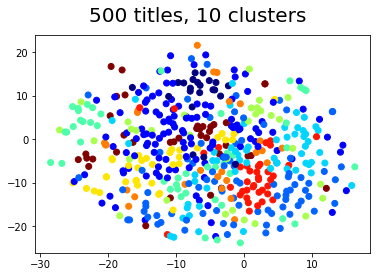

In [34]:
plt.scatter(dtm2_svd_vis_df.iloc[: , :1], dtm2_svd_vis_df.iloc[: , -1:], c = clusters_ti, cmap=plt.cm.get_cmap("jet", 10))
plt.suptitle('500 titles, 10 clusters', fontsize=20)

In [35]:
print_topic_top_words(pipe)

                                    Topic 1:                                    
disease alzheimer cognitive biomarkers analysis
--------------------------------------------------------------------------------
                                    Topic 2:                                    
amyloid beta tau peptide induced
--------------------------------------------------------------------------------
                                    Topic 3:                                    
dementia cognitive study impairment risk
--------------------------------------------------------------------------------
                                    Topic 4:                                    
neurodegenerative diseases review role disorders
--------------------------------------------------------------------------------
                                    Topic 5:                                    
cognitive mice impairment transgenic brain
---------------------------------------------------------